http://topotools.cr.usgs.gov/GMTED_viewer/
https://topotools.cr.usgs.gov/gmted_viewer/viewer.htm

In [1]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib import colors
import rasterio.merge
import glob
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
from shapely.geometry import mapping
from rasterio import mask as msk 

In [2]:
tif_files = glob.glob('/Users/kmt/Downloads/africa_tif/*')
# tif_files = glob.glob('/Users/kmt/Downloads/africa_75_tif/*')
# tif_files = glob.glob('/Users/kmt/Downloads/africa_150_tif/*')
data = [rasterio.open(f) for f in tif_files]
dest, output_transform = rasterio.merge.merge(data)

with rasterio.open(tif_files[0]) as src:
    out_meta = src.meta.copy()    
out_meta.update({"driver": "GTiff",
                 "height": dest.shape[1],
                 "width": dest.shape[2],
                 "transform": output_transform})
with rasterio.open("mergedRasters.tif", "w", **out_meta) as dest1:
    dest1.write(dest)

In [3]:
file = rasterio.open('mergedRasters.tif')
dataset = file.read()

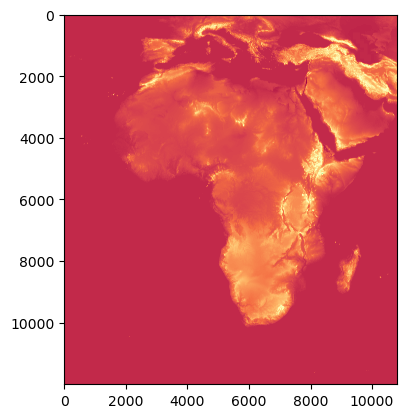

In [4]:
plt.imshow(dataset[0], cmap='Spectral')

plt.show()

Suggested citation:
Danielson, J.J., and Gesch, D.B., 2011, Global multi-resolution terrain elevation data 2010 (GMTED2010): U.S. Geological Survey Open-File Report 2011–1073, 26 p.

http://pubs.usgs.gov/of/2011/1073/

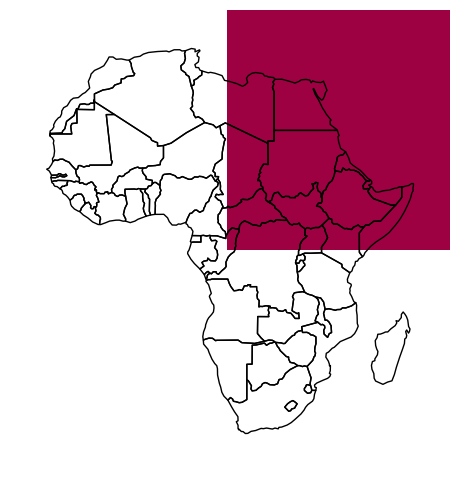

In [41]:
# df = gpd.read_file('NaturalEarth/data/10m_cultural/ne_10m_admin_0_countries.shp')
# world = gpd.read_file('../metadata/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
world = gpd.read_file('../natural_earth/110m_cultural/ne_110m_admin_0_countries.shp')
# df = gpd.read_file('../natural_earth/50m_physical/ne_50m_land.shp')

africa = world.loc[world['CONTINENT'] == 'Africa']

_mapping = [mapping(africa.iloc[i].geometry) for i in range(africa.index.size)]
clipped_array, clipped_transform = msk.mask(file, _mapping, crop=True)


#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = gplt.polyplot(africa, projection=gcrs.PlateCarree(), zorder=10)

ax.imshow(clipped_array[0], cmap='Spectral') ;



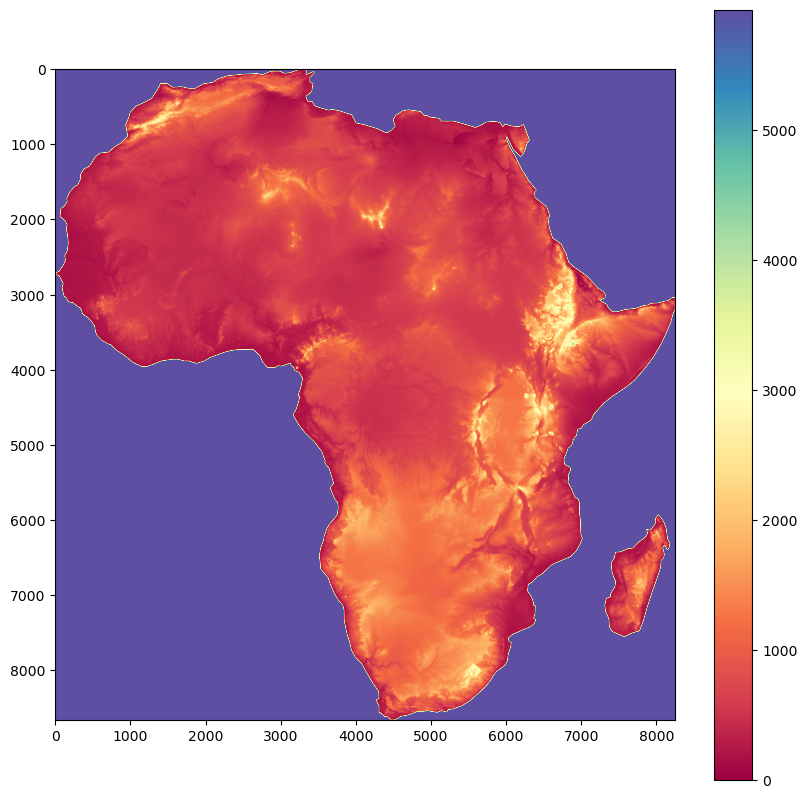

In [13]:
import numpy as np
from rasterio import mask as msk 

def clip_raster(gdf, img):
    clipped_array, clipped_transform = msk.mask(img, _mapping, crop=True)
    clipped_array, clipped_transform = msk.mask(img, _mapping, crop=True, nodata=(np.amax(clipped_array[0]) + 1))
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range
 
africa_topography, value_range = clip_raster(africa, file)

plt.figure(figsize=(10,10))
c = plt.imshow(africa_topography[0], cmap='Spectral')
plt.colorbar(c) ;

In [14]:
from matplotlib.colors import LinearSegmentedColormap
africa_colormap = LinearSegmentedColormap.from_list('africa', ['#008C45', '#0b914c', '#F4F5F0', '#cf2a32', '#CD212A'], N=value_range)

In [15]:
from matplotlib.colors import ListedColormap

background_color = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = africa_colormap(np.linspace(0, 1, value_range))
newcolors = np.vstack((newcolors, background_color))
africa_colormap = ListedColormap(newcolors)

In [16]:
import matplotlib.colors

class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
# colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 56))
# colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
colors_undersea = plt.cm.gist_earth(np.linspace(0, 0.17, 56))
colors_land = plt.cm.gist_earth(np.linspace(0.25, 1, 200))
# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors)

norm5 = FixPointNormalize(sealevel=0, vmax=4800)
# im5 = ax[1,1].imshow(data, norm=norm5, cmap=cut_terrain_map)
# cbar = fig.colorbar(im5, ax=ax[1,1])

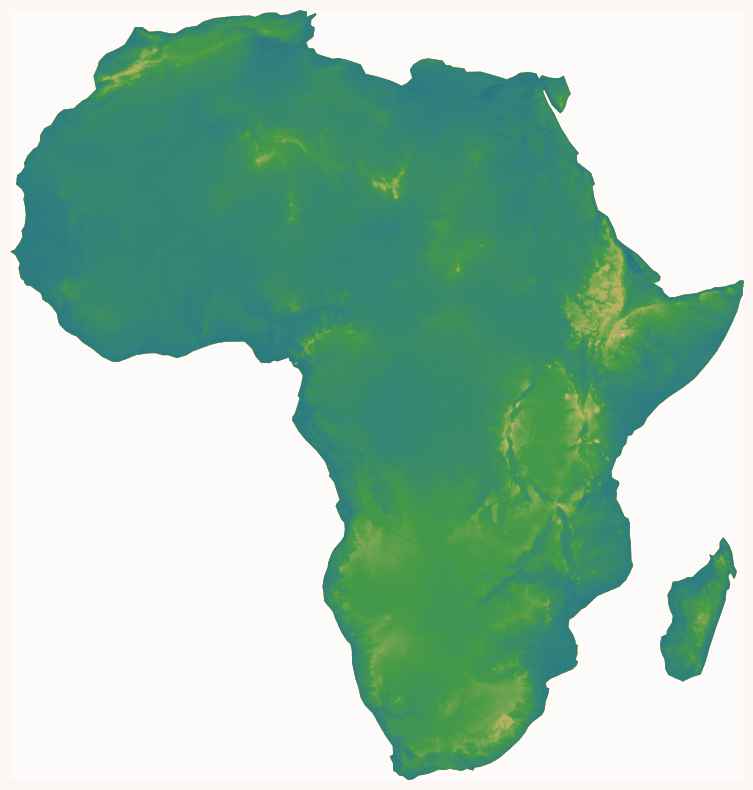

In [17]:
gplt.polyplot(africa, projection=gcrs.PlateCarree())

fig = plt.figure(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 10)
ax = plt.axes()
# plt.imshow(italy_topography[0], cmap=italy_colormap)
# plt.imshow(italy_topography[0], cmap='gist_earth')
plt.imshow(africa_topography[0], norm=norm5, cmap=cut_terrain_map)
ax.axis('off') ;

In [19]:
#ax = gplt.polyplot(africa)

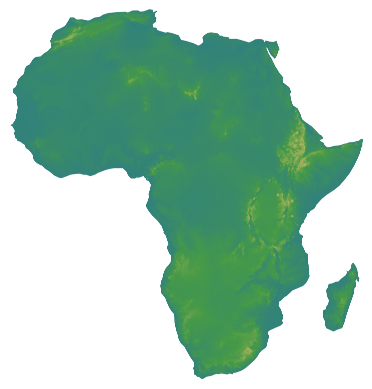

In [47]:
from matplotlib.colors import Normalize
vmax = africa_topography[0].max()
vmin = africa_topography[0].min()

# # Create an alpha channel based on weight values
# # Any value whose absolute value is > .0001 will have zero transparency
# alphas = Normalize(0, 6115, clip=True)(np.abs(africa_topography[0]))
# # alphas = np.clip(alphas, 0, 0.4)  # alpha value clipped at the bottom at .4

# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(vmin, vmax)(africa_topography[0])
colors = colors * (1-0.25) + 0.25 # Shift colors off the blues
colors = cut_terrain_map(colors)

alphas = (africa_topography[0] < africa_topography[0][0, 0]).astype('int') # top left cell is the value we weant to mask as transparent

# Now set the alpha channel to the one we created above
# colors[..., -1] = alphas
colors[..., -1] = alphas

grays = np.full((*africa_topography[0].shape, 3), 70, dtype=np.uint8) # for background to fade onto

# Create the figure and image
# Note that the absolute values may be slightly different
fig, ax = plt.subplots()
#ax.imshow(grays)
ax.imshow(colors, cmap=cut_terrain_map)
ax.axis('off')
plt.savefig('demo.png', transparent=True) ;

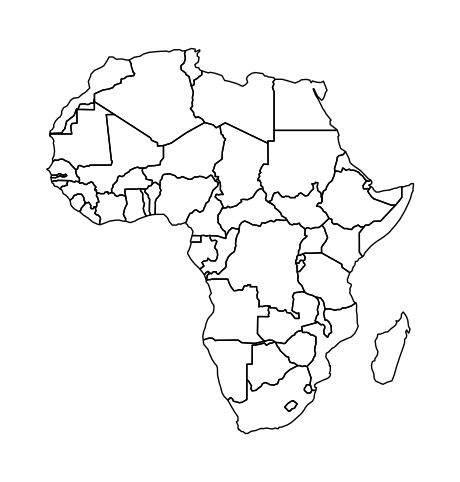

In [46]:


#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = gplt.polyplot(africa, projection=gcrs.PlateCarree(), zorder=1)
plt.savefig('demo2.png', transparent=True) ;

In [21]:
import earthpy.spatial as es

hillshade = es.hillshade(africa_topography[0], azimuth=240, altitude=10)
#hillshade = es.hillshade(italy_topography[0])

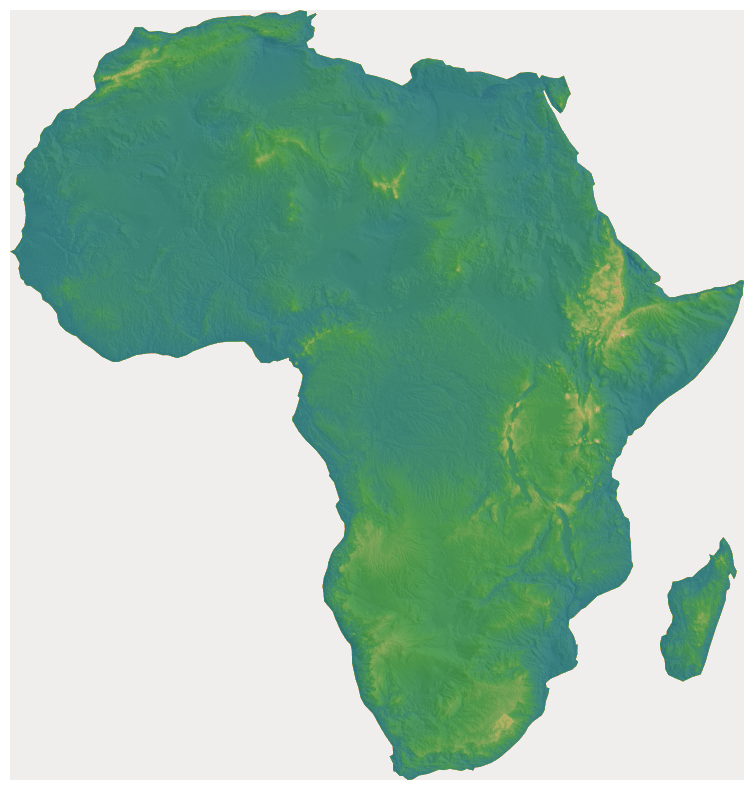

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
# i = plt.imshow(italy_topography[0], cmap=italy_colormap, norm=colors.LogNorm())
plt.imshow(africa_topography[0], norm=norm5, cmap=cut_terrain_map)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
ax.axis('off')
#plt.savefig('demo.png', transparent=True) ;

<GeoAxes: >

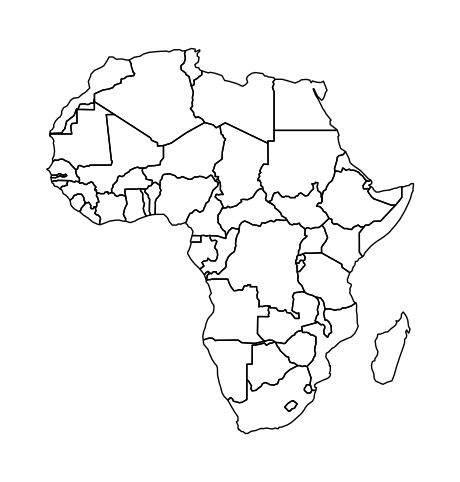

In [27]:
import geoplot as gplt
import geoplot.crs as gcrs
import geopand



In [26]:
dir(gcrs)

['AlbersEqualArea',
 'AzimuthalEquidistant',
 'Base',
 'EckertI',
 'EckertII',
 'EckertIII',
 'EckertIV',
 'EckertV',
 'EckertVI',
 'EqualEarth',
 'EuroPP',
 'Filtering',
 'Geostationary',
 'Gnomonic',
 'InterruptedGoodeHomolosine',
 'LambertAzimuthalEqualArea',
 'LambertConformal',
 'LambertCylindrical',
 'LatitudeCentering',
 'LongitudeCentering',
 'LongitudeLatitudeCentering',
 'Mercator',
 'Miller',
 'Mollweide',
 'NearsidePerspective',
 'NorthPolarStereo',
 'OSGB',
 'OSNI',
 'Orthographic',
 'PlateCarree',
 'Robinson',
 'Sinusoidal',
 'SouthPolarStereo',
 'Stereographic',
 'TransverseMercator',
 'WebMercator',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'ccrs',
 'gpd']